# Imports

In [1]:
import numpy as np
import pandas as pd # 1.1
from sklearn.preprocessing import StandardScaler # 1.2
from sklearn.model_selection import train_test_split # 1.4
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm

In [3]:
# FOR SVR Baseline model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# 1. Data Preprocessing

## 1.1 Get Data

### Player Data

In [4]:
player_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/nba_players.csv'
player_df = pd.read_csv(player_data_url)
player_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,mathcup,gamedate,winloss,minuters,pts,fgm,...,dreb,reb,ast,stl,blk,tov,pfo,plusminus,fp1,player
0,1710822472-1,https://www.nba.com/stats/players/boxscores,NaN,ATL,ATL @ LAL,03/18/2024,NaN,13,8,4,...,4,8,0,1,1,1,1,-7,22.6,Clint Capela
1,1710822472-2,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,19,8,3,...,3,4,3,2,2,1,2,-1,28.3,Mo Bamba
2,1710822472-3,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,16,11,4,...,1,2,1,1,1,0,1,1,20.9,Thomas Bryant
3,1710822472-4,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,32,20,8,...,10,13,6,0,0,4,1,-19,40.6,Bam Adebayo
4,1710822472-5,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,24,12,4,...,1,2,1,0,1,1,1,11,17.9,Buddy Hield


In [5]:
player_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'mathcup', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'fp1', 'player'],
      dtype='object')

In [6]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage', 'fp1']
player_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
player_df['gamedate'] = pd.to_datetime(player_df['gamedate'])
player_df = player_df[player_df['gamedate'] != '2024-03-18']

# NBA made a typo so we gotta fix that
player_df['matchup'] = player_df['mathcup']
player_df.drop(columns=['mathcup'], inplace=True)

<ipython-input-6-2dcc550019b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['matchup'] = player_df['mathcup']
<ipython-input-6-2dcc550019b0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df.drop(columns=['mathcup'], inplace=True)


In [7]:
def calculate_fantasy_points(row):
    # Points scored
    points_scored = row['pts'] * 0.5
    # Rebounds, Assists, Steals, and Blocks
    rebound_points = (row['oreb'] + row['dreb']) * 1
    assist_points = row['ast'] * 1
    steal_points = row['stl'] * 2
    block_points = row['blk'] * 2
    # Turnovers
    turnover_points = row['tov'] * -1
    # Three-points made
    three_points = row['3pm'] * 0.5
    # Double-Double and Triple-Double
    double_digits = sum(i >= 10 for i in [row['pts'], row['oreb'] + row['dreb'], row['ast'], row['stl'], row['blk']])
    double_double_points = 1.0 if double_digits >= 2 else 0
    triple_double_points = 2.0 if double_digits >= 3 else 0
    # 40+ and 50+ bonuses
    fourty_pt_bonus = 2.0 * (row['pts'] >= 40)
    fifty_pt_bonus = 2.0 * (row['pts'] >= 50)
    # Total fantasy points
    total_points = (points_scored + rebound_points + assist_points +
                    steal_points + block_points + turnover_points + three_points +
                    double_double_points + triple_double_points +
                    fourty_pt_bonus + fifty_pt_bonus)
    return total_points

In [8]:
def get_opp_team(matchup):
    if '@' in matchup:
        return matchup.split(' @ ')[1]
    elif 'vs.' in matchup:
        return matchup.split(' vs. ')[1]
    else:
        return None

In [9]:
# Helper function to determine home and away teams
def extract_teams(matchup):
    teams_a = matchup.split(' @ ')
    teams_h = matchup.split(' vs. ')
    if '@' in matchup:
        return teams_a[1], teams_a[0]
    else:
        return teams_h[0], teams_h[1]

# Function to create game_id
def create_game_id(row):
    home_team, away_team = extract_teams(row['matchup'])
    game_date = row['gamedate'].strftime('%Y-%m-%d')
    return f"{home_team}.{away_team}.{game_date}"

In [10]:
player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L
player_df['fp'] = player_df.apply(calculate_fantasy_points, axis=1) # calculate fantasy points
player_df['opp_team'] = player_df['matchup'].apply(get_opp_team) # extract the opponent team name
player_df['game_id'] = player_df.apply(create_game_id, axis=1) # calculate the game id

# calculate how many days has passed since the start of the season till this game
season_start_date = pd.Timestamp('2023-10-24')
player_df['days_since'] = (player_df['gamedate'] - season_start_date).dt.days

player_df.head()

,team,gamedate,winloss,minuters,pts,fgm,fga,fgpercent,3pm,3pa,...,tov,pfo,plusminus,player,matchup,is_home,fp,opp_team,game_id,days_since
152,BOS,2024-03-17,1,35,14,6,15,40.0,2,5,...,1,0,16,Payton Pritchard,BOS @ WAS,0,28.0,WAS,WAS.BOS.2024-03-17,145
153,BOS,2024-03-17,1,23,9,3,7,42.9,3,6,...,0,0,7,Svi Mykhailiuk,BOS @ WAS,0,13.0,WAS,WAS.BOS.2024-03-17,145
154,BOS,2024-03-17,1,20,14,5,9,55.6,0,0,...,1,1,9,Luke Kornet,BOS @ WAS,0,17.0,WAS,WAS.BOS.2024-03-17,145
155,WAS,2024-03-17,0,22,8,4,7,57.1,0,2,...,0,3,-17,Johnny Davis,WAS vs. BOS,1,13.0,BOS,WAS.BOS.2024-03-17,145
156,WAS,2024-03-17,0,15,0,0,1,0.0,0,1,...,1,2,-14,Eugene Omoruyi,WAS vs. BOS,1,3.0,BOS,WAS.BOS.2024-03-17,145


In [11]:
player_df.columns

Index(['team', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'player', 'matchup', 'is_home', 'fp', 'opp_team', 'game_id',
       'days_since'],
      dtype='object')

### Team Data

In [12]:
team_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/teamscores.csv'
team_df = pd.read_csv(team_data_url)

In [13]:
team_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,matchup,date,winloss,min,pts,fgm,...,ftpercent,oreb,dreb,reb,ast,stl,blk,tov,pfidk,plusminus
0,1710880555-1,https://www.nba.com/stats/teams/boxscores,NaN,CLE,CLE @ IND,03/18/2024,W,240,108,38,...,71.4,9,30,39,27,8,4,14,18,5
1,1710880555-2,https://www.nba.com/stats/teams/boxscores,NaN,IND,IND vs. CLE,03/18/2024,L,240,103,42,...,62.5,14,31,45,28,8,3,11,24,-5
2,1710880555-3,https://www.nba.com/stats/teams/boxscores,NaN,DET,DET @ BOS,03/18/2024,L,240,94,36,...,86.7,8,35,43,21,6,3,13,15,-25
3,1710880555-4,https://www.nba.com/stats/teams/boxscores,NaN,BOS,BOS vs. DET,03/18/2024,W,240,119,43,...,84.6,15,38,53,30,8,8,11,9,25
4,1710880555-5,https://www.nba.com/stats/teams/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,240,98,37,...,91.7,7,39,46,23,7,12,12,16,7


In [14]:
team_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'matchup', 'date', 'winloss', 'min', 'pts', 'fgm', 'fga', 'fgpercent',
       '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'tov', 'pfidk', 'plusminus'],
      dtype='object')

In [15]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage']
team_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
team_df['gamedate'] = pd.to_datetime(team_df['date'])
team_df = team_df[team_df['gamedate'] != '2024-03-18']

In [16]:
team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
team_df['game_id'] = team_df.apply(create_game_id, axis=1)
team_df.head()

<ipython-input-16-a5d1a32ab59e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
<ipython-input-16-a5d1a32ab59e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
<ipython-input-16-a5d1a32ab59e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,team,matchup,date,winloss,min,pts,fgm,fga,fgpercent,3pm,...,ast,stl,blk,tov,pfidk,plusminus,gamedate,is_home,opp_team,game_id
16,LAC,LAC vs. ATL,03/17/2024,L,240,93,28,74,37.8,11,...,17,10,5,16,13,-17,2024-03-17,1,ATL,LAC.ATL.2024-03-17
17,ATL,ATL @ LAC,03/17/2024,W,240,110,41,84,48.8,17,...,32,10,7,16,22,17,2024-03-17,0,LAC,LAC.ATL.2024-03-17
18,BKN,BKN @ SAS,03/17/2024,L,265,115,47,102,46.1,8,...,29,13,5,12,20,-7,2024-03-17,0,SAS,SAS.BKN.2024-03-17
19,SAS,SAS vs. BKN,03/17/2024,W,265,122,46,99,46.5,9,...,30,6,10,18,17,7,2024-03-17,1,BKN,SAS.BKN.2024-03-17
20,ORL,ORL vs. TOR,03/17/2024,W,240,111,43,85,50.6,11,...,22,7,4,15,16,15,2024-03-17,1,TOR,ORL.TOR.2024-03-17


News Data

In [17]:
news_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/playernews_final_updated_2024.xlsx'
news_df = pd.read_excel(news_data_url)

In [18]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url']
news_df.drop(columns=columns_to_remove, inplace=True)

# Convert 'time_interval' to datetime
news_df['date'] = pd.to_datetime(news_df['time_interval'], errors='coerce')

# Checking the converted dates and if there are any parsing errors or null values
news_df[['time_interval', 'date']].head(), news_df['date'].isnull().sum()

(  time_interval       date
 0    06/13/2023 2023-06-13
 1    06/13/2023 2023-06-13
 2    06/13/2023 2023-06-13
 3    06/12/2023 2023-06-12
 4    06/12/2023 2023-06-12,
 0)

### Merging

In [19]:
own_team_df = team_df.copy()
opp_team_df = team_df.copy()

In [20]:
# renaming columns for the team data
team_rename_columns = {
    'pts': 'team_pts',
    'fgm': 'team_fgm',
    'fga': 'team_fga',
    'fgpercent': 'team_fgpercent',
    '3pm': 'team_3pm',
    '3pa': 'team_3pa',
    '3ppercent': 'team_3ppercent',
    'ftm': 'team_ftm',
    'fta': 'team_fta',
    'ftpercent': 'team_ftpercent',
    'oreb': 'team_oreb',
    'dreb': 'team_dreb',
    'reb': 'team_reb',
    'ast': 'team_ast',
    'stl': 'team_stl',
    'blk': 'team_blk',
    'tov': 'team_tov',
    'pfidk': 'team_pfidk',
    'plusminus': 'team_plusminus'
}

# renaming columns for the opponent team data
opp_rename_columns = {
    'pts': 'opp_pts',
    'fgm': 'opp_fgm',
    'fga': 'opp_fga',
    'fgpercent': 'opp_fgpercent',
    '3pm': 'opp_3pm',
    '3pa': 'opp_3pa',
    '3ppercent': 'opp_3ppercent',
    'ftm': 'opp_ftm',
    'fta': 'opp_fta',
    'ftpercent': 'opp_ftpercent',
    'oreb': 'opp_oreb',
    'dreb': 'opp_dreb',
    'reb': 'opp_reb',
    'ast': 'opp_ast',
    'stl': 'opp_stl',
    'blk': 'opp_blk',
    'tov': 'opp_tov',
    'pfidk': 'opp_pfidk',
    'plusminus': 'opp_plusminus'
}

own_team_df.rename(columns=team_rename_columns, inplace=True)
opp_team_df.rename(columns=opp_rename_columns, inplace=True)

In [21]:
opp_team_df.columns

Index(['team', 'matchup', 'date', 'winloss', 'min', 'opp_pts', 'opp_fgm',
       'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent',
       'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb', 'opp_dreb',
       'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov', 'opp_pfidk',
       'opp_plusminus', 'gamedate', 'is_home', 'opp_team', 'game_id'],
      dtype='object')

In [22]:
# merging player data with own team data
initial_merged_df = pd.merge(player_df, own_team_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from team_df that are redundant
initial_merged_df.drop([col for col in initial_merged_df.columns if 'drop' in col], axis=1, inplace=True)

# merging the last df with opponent team data
df = pd.merge(initial_merged_df, opp_team_df, left_on=['game_id', 'opp_team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from opp_team_df that are redundant
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)

In [23]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'opp_team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'opp_team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_oreb,opp_dreb,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,10,30,40,24,3,5,16,20,-26,28.0
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,10,30,40,24,3,5,16,20,-26,13.0
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,10,30,40,24,3,5,16,20,-26,17.0
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,10,30,40,24,3,5,16,20,-26,29.0
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,10,30,40,24,3,5,16,20,-26,1.0


In [24]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

## 1.2 Z-Score Normalization / Standardization

In [25]:
"""
# Select the columns with player stats
stats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here

# Initialize the scaler
scaler = StandardScaler()

# Normalize the stats using Z-score normalization
df[stats_columns] = scaler.fit_transform(df[stats_columns])
"""

"\n# Select the columns with player stats\nstats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here\n\n# Initialize the scaler\nscaler = StandardScaler()\n\n# Normalize the stats using Z-score normalization\ndf[stats_columns] = scaler.fit_transform(df[stats_columns])\n"

## 1.25: EXPERIMENTAL REMOVING OF MORE COLUMNS TO SIMPLIFY THE MODEL

In [26]:
# EXPERIMENTAL:
more_columns_to_remove = \
 ['opp_team', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent', 'ftm',
  'fta', 'ftpercent', 'pfo', 'plusminus', 'matchup', 'is_home', 'date', 'min',
  'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm', 'team_3pa',
  'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent', 'team_oreb',
  'team_dreb', 'team_reb', 'team_ast', 'team_stl', 'team_blk', 'team_tov',
  'team_pfidk', 'team_plusminus', 'opp_pts', 'opp_fgm', 'opp_fga',
  'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent', 'opp_ftm', 'opp_fta',
  'opp_ftpercent', 'opp_oreb', 'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl',
  'opp_blk', 'opp_tov', 'opp_pfidk', 'opp_plusminus']
# df.drop(columns=more_columns_to_remove, inplace=True)

In [27]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

In [28]:
# Create a boolean mask
mask = (df == '-')

# Use `any` to check each column
columns_with_dash = mask.any(axis=0)

# Print the columns that contain '-'
print(columns_with_dash[columns_with_dash].index.tolist())

# Convert specific columns to strings
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].astype(str)

# Replace '-' with '0'
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].replace('-', '0')

# Convert these columns back to floats
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].astype(float)


['fgpercent', '3ppercent', 'ftpercent']


## 1.275: EXPERIMENTAL REMOVING OF PLAYERS THAT HAVENT PLAYED 10 GAMES AND THAT ARE NOT IN TOP 150

In [29]:
# Filter out players who have played less than 10 games
game_counts = df['player'].value_counts()
players_at_least_10_games = game_counts[game_counts >= 10].index
filtered_df = df[df['player'].isin(players_at_least_10_games)]

# Compute season average fantasy points for each player
season_averages = filtered_df.groupby('player')['fp'].mean().reset_index().sort_values(by='fp', ascending=False)

# Keep only the top 150 players in terms of season average
top_players = season_averages.head(150)['player']
simple_df = filtered_df[filtered_df['player'].isin(top_players)]

In [30]:
simple_df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_oreb,opp_dreb,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp
6,Jayson Tatum,BOS,WAS,2024-03-17,145,1,27,30,8,17,...,10,30,40,24,3,5,16,20,-26,36.0
7,Jrue Holiday,BOS,WAS,2024-03-17,145,1,22,7,3,7,...,10,30,40,24,3,5,16,20,-26,11.0
8,Al Horford,BOS,WAS,2024-03-17,145,1,23,14,5,7,...,10,30,40,24,3,5,16,20,-26,13.0
14,Jordan Poole,WAS,BOS,2024-03-17,145,0,23,31,12,19,...,12,31,43,30,9,6,15,17,26,22.0
21,Luka Doncic,DAL,DEN,2024-03-17,145,1,40,37,12,27,...,6,31,37,26,7,6,8,16,-2,36.0


1.29. ADDING MORE FEATURES FOR DEBUGGING

In [31]:
players_list = list(df.groupby('player')['fp'].mean().reset_index().sort_values(by='fp', ascending=False)['player'])
players_dict = {players_list[i]: i for i in range(len(players_list))}
players_inv_dict = {i: players_list[i] for i in range(len(players_list))}

In [32]:
int(str(df.iloc[132]['gamedate'])[-14:-12]) * 1000 + int(str(df.iloc[132]['gamedate'])[-11:-9])

3017

In [33]:
def intify_player(player):
    return players_dict[player] / 1000

def intify_gamedate(gamedate):
    return (int(str(gamedate)[-14:-12]) * 1000 + int(str(gamedate)[-11:-9])) / 100000

In [34]:
df['int_player'] = df['player'].apply(intify_player)
df['int_gamedate'] = df['gamedate'].apply(intify_gamedate)

In [35]:
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp,int_player,int_gamedate
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,40,24,3,5,16,20,-26,28.0,0.230,0.03017
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,40,24,3,5,16,20,-26,13.0,0.455,0.03017
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,40,24,3,5,16,20,-26,17.0,0.263,0.03017
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,40,24,3,5,16,20,-26,29.0,0.240,0.03017
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,40,24,3,5,16,20,-26,1.0,0.295,0.03017


## 1.3 One-Hot Encoding

In [36]:
# one-hot encode the categorical columns
df = pd.get_dummies(df, columns=['opp_team', 'team'])

In [37]:
## reorder the columns for visual purposes
columns_order = ['player', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]

In [38]:
df.head()

,player,gamedate,days_since,winloss,minuters,pts,fgm,fga,fgpercent,3pm,...,team_ORL,team_PHI,team_PHX,team_POR,team_SAC,team_SAS,team_TOR,team_UTA,team_WAS,fp
0,Payton Pritchard,2024-03-17,145,1,35,14,6,15,40.0,2,...,False,False,False,False,False,False,False,False,False,28.0
1,Svi Mykhailiuk,2024-03-17,145,1,23,9,3,7,42.9,3,...,False,False,False,False,False,False,False,False,False,13.0
2,Luke Kornet,2024-03-17,145,1,20,14,5,9,55.6,0,...,False,False,False,False,False,False,False,False,False,17.0
3,Sam Hauser,2024-03-17,145,1,23,30,10,13,76.9,10,...,False,False,False,False,False,False,False,False,False,29.0
4,Neemias Queta,2024-03-17,145,1,8,0,0,0,0.0,0,...,False,False,False,False,False,False,False,False,False,1.0


In [39]:
df.columns

Index(['player', 'gamedate', 'days_since', 'winloss', 'minuters', 'pts', 'fgm',
       'fga', 'fgpercent', '3pm',
       ...
       'team_ORL', 'team_PHI', 'team_PHX', 'team_POR', 'team_SAC', 'team_SAS',
       'team_TOR', 'team_UTA', 'team_WAS', 'fp'],
      dtype='object', length=130)

## 1.4 Split per player



In [40]:
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

# Load GloVe embeddings
glove = GloVe(name='6B', dim=100)

# Tokenizer from torchtext
tokenizer = get_tokenizer('basic_english')

# Function to convert tokens to indices
def text_to_indices(text, vocab):
    tokens = tokenizer(text)
    indices = [vocab.get(token, 0) for token in tokens]  # Use `0` for tokens not found in vocab
    return indices

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 17405.79it/s]


In [41]:
def count_players_with_news(dataframe, news_dataframe, look_back_days=14):
    players_with_news = 0
    players = dataframe['player'].unique()

    for player in players:
        player_data = dataframe[dataframe['player'] == player]
        last_game_date = player_data['gamedate'].max()
        start_date = last_game_date - pd.Timedelta(days=look_back_days)

        # Filter news data for the current player within the last 14 days
        news_mask = (news_dataframe['player_name'] == player) & (news_dataframe['date'] >= start_date) & (news_dataframe['date'] <= last_game_date)
        news_count = news_dataframe[news_mask].shape[0]

        if news_count > 0:
            players_with_news += 1

    return players_with_news

# Example usage
players_with_news_count = count_players_with_news(df, news_df)
print(f"Number of players with news in the last 14 days: {players_with_news_count}")

Number of players with news in the last 14 days: 446


In [ ]:
def count_players_without_news(dataframe, news_dataframe, look_back_days=14):
    players_without_news = 0
    players = dataframe['player'].unique()

    for player in players:
        player_data = dataframe[dataframe['player'] == player]
        last_game_date = player_data['gamedate'].max()
        start_date = last_game_date - pd.Timedelta(days=look_back_days)

        # Filter news data for the current player within the last 14 days
        news_mask = (news_dataframe['player_name'] == player) & (news_dataframe['date'] >= start_date) & (news_dataframe['date'] <= last_game_date)
        news_count = news_dataframe[news_mask].shape[0]

        if news_count == 0:
            players_without_news += 1

    return players_without_news

# Example usage
players_without_news_count = count_players_without_news(df, news_df)
print(f"Number of players with news in the last 14 days: {players_without_news_count}")

In [42]:
class NBAFantasyDataset(Dataset):
    def __init__(self, dataframe, news_df, game_look_back=10, news_look_back=1, glove_vocab=None):
        """
        Args:
            dataframe (pandas.DataFrame): The dataframe containing the fantasy data.
            news_dataframe (pandas.DataFrame): The dataframe containing the news data.
            game_look_back (int): Number of past games to consider for each sample.
            glove_vocab (torchtext.vocab.Vocab): Vocabulary object containing GloVe word embeddings.
        """
        self.dataframe = dataframe
        self.look_back = game_look_back
        self.glove_vocab = glove_vocab

        # Prepare the news data
        self.news_dataframe = news_df
        self._prepare_news_data()

        # Prepare player games indices
        self.player_game_indices = self._get_player_game_indices()

        # Normalize features
        self.scaler = StandardScaler()
        self._normalize_features()

    def _prepare_news_data(self):

        # Convert news date to datetime format
        self.news_dataframe['date'] = pd.to_datetime(self.news_dataframe['time_interval'], errors='coerce')
        self.news_dataframe = self.news_dataframe.drop(columns=['time_interval'])
        # Assume `player_name` in news_dataframe aligns with `player` in dataframe
        self.news_dataframe.rename(columns={'player_name': 'player'}, inplace=True)

    def _get_player_game_indices(self):
        player_game_indices = []
        players = self.dataframe['player'].unique()
        for player in players:
            player_data = self.dataframe[self.dataframe['player'] == player]
            for i in range(self.look_back, len(player_data)):
                start_index = player_data.index[i-self.look_back]
                end_index = player_data.index[i]
                player_game_indices.append((start_index, end_index))
        return player_game_indices

    def _normalize_features(self):
        features = self.dataframe.drop(columns=['player', 'gamedate', 'game_id', 'fp', 'matchup', 'date'])
        self.scaler.fit(features)
        self.dataframe.loc[:, features.columns] = self.scaler.transform(features)


    def _get_news_for_player(self, player, date):
        end_date = date
        start_date = end_date - pd.Timedelta(days=self.look_back)
        mask = (self.news_dataframe['player'] == player) & (self.news_dataframe['date'] >= start_date) & (self.news_dataframe['date'] <= end_date)
        news_items = self.news_dataframe.loc[mask, ['title', 'short', 'long']].fillna('')

        # Creating a single string from the news items DataFrame
        if not news_items.empty:
            news_text = ' '.join(news_items.apply(lambda x: ' '.join(x.astype(str)), axis=1))
            return text_to_indices(news_text, self.glove_vocab)

        return [0] # Return a fixed-length zero vector if no news


    def __len__(self):
        return len(self.player_game_indices)

    def __getitem__(self, idx):
        start_index, end_index = self.player_game_indices[idx]
        player_data = self.dataframe.iloc[start_index:end_index]
        player = self.dataframe.iloc[end_index]['player']
        gamedate = self.dataframe.iloc[end_index]['gamedate']

        features = player_data.drop(columns=['player', 'gamedate', 'game_id', 'fp', 'matchup', 'date']).astype(float).fillna(0.0).values

        target = self.dataframe.iloc[end_index]['fp']

        news_features = self._get_news_for_player(player, gamedate)
        if news_features is None:
            news_features = [0]

        features_tensor = torch.tensor(features, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)
        news_tensor = torch.tensor(news_features, dtype=torch.long)

        return news_tensor, features_tensor, target_tensor

In [45]:
sorted_df = df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True)

In [43]:
def collate_fn(batch):
    """
    Custom collate function for handling variable-length sequences.
    """
    news, features, targets= zip(*batch)

    features_padded = torch.nn.utils.rnn.pad_sequence(features, batch_first=True, padding_value=0)
    news_padded = torch.nn.utils.rnn.pad_sequence(news, batch_first=True, padding_value=0)

    targets = torch.stack(targets)


    return news_padded, features_padded, targets

In [46]:
batch_size = 32 # we can change this if needed

# Instantiate the dataset
dataset = NBAFantasyDataset(sorted_df, news_df, game_look_back=10, news_look_back=14, glove_vocab=glove.stoi)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

## 1.5 Train-Test Split

In [47]:
# Define the split sizes
TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0)

In [ ]:
# print(df.columns)
# print(simple_df.columns)

In [ ]:
# len(simple_df)

## Testing the Model

100%|██████████| 208/208 [00:45<00:00,  4.52it/s]


Accuracy (within ±5 FP): 73.75%
Mean Squared Error Loss: 24.8572


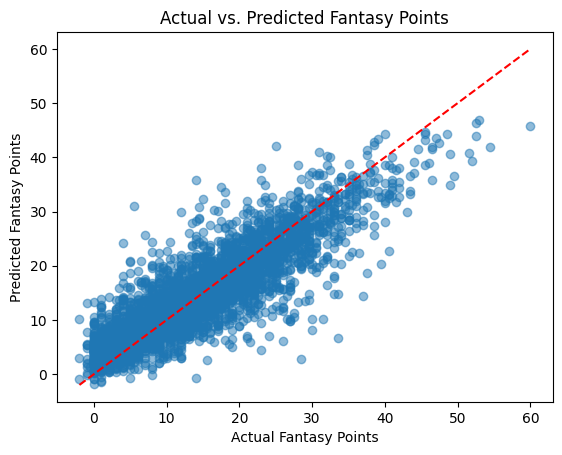

(0.7374924653405666, 24.857169524981426)

In [110]:
def evaluate_model(model, dataloader, threshold, device):
    model.to(device)
    model.eval()
    total_hits = 0
    total_samples = 0
    total_mse_loss = 0
    criterion = nn.MSELoss()
    actual_fps = []
    predicted_fps = []

    with torch.no_grad():
        for news, features, targets in tqdm(dataloader):
            news, features, targets = news.to(device), features.to(device), targets.to(device)
            outputs = model(news, features).squeeze()
            mse_loss = criterion(outputs, targets)
            total_mse_loss += mse_loss.item()
            hits = torch.abs(outputs - targets) <= threshold
            total_hits += hits.sum().item()
            total_samples += targets.size(0)
            actual_fps.extend(targets.cpu().numpy())
            predicted_fps.extend(outputs.cpu().numpy())

    accuracy_rate = total_hits / total_samples
    average_mse_loss = total_mse_loss / len(dataloader)
    print(f'Accuracy (within ±{threshold} FP): {accuracy_rate * 100:.2f}%')
    print(f'Mean Squared Error Loss: {average_mse_loss:.4f}')

    # Plot actual vs. predicted fantasy points
    plt.scatter(actual_fps, predicted_fps, alpha=0.5)
    plt.xlabel('Actual Fantasy Points')
    plt.ylabel('Predicted Fantasy Points')
    plt.title('Actual vs. Predicted Fantasy Points')
    plt.plot([min(actual_fps), max(actual_fps)], [min(actual_fps), max(actual_fps)], 'r--')  # Diagonal line for reference
    plt.show()

    return accuracy_rate, average_mse_loss

evaluate_model(model, test_dataloader, 5, 'cuda')


100%|██████████| 830/830 [03:17<00:00,  4.21it/s]


Accuracy (within ±5 FP): 79.07%
Mean Squared Error Loss: 17.3938


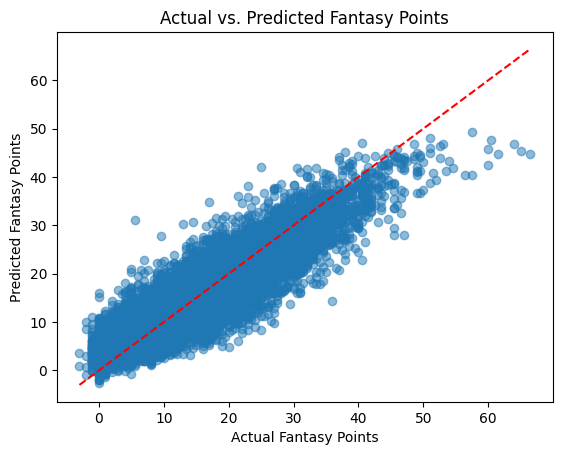

(0.7907467410142416, 17.39382394710219)

In [111]:
evaluate_model(model, train_dataloader, 5, 'cuda')

## NLP-Augmented LSTM?

In [ ]:
import torch
import torch.nn as nn
from torchtext.vocab import GloVe

# Load GloVe embeddings (e.g., '6B' 100-dimensional version)
def load_glove_embeddings(dim=100):
    glove = GloVe(name='6B', dim=dim)
    return glove

glove = load_glove_embeddings()

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, num_filters, filter_sizes):
        super(TextCNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=1,  # One channel input
                      out_channels=num_filters,
                      kernel_size=fs,
                      padding='same') for fs in filter_sizes  # Padding to keep size
        ])
        self.pool = nn.AdaptiveMaxPool1d(1)  # Adaptive pooling to a fixed size output

    def forward(self, text_data):
        text_data = text_data.float()  # Convert to float

        # Add channel dimension because Conv1d expects [batch, channels, length]
        if text_data.dim() == 2:
            text_data = text_data.unsqueeze(1)

        cnn_outs = [F.relu(conv(text_data)) for conv in self.convs]  # Apply each convolution
        cnn_outs = [self.pool(co).squeeze(2) for co in cnn_outs]  # Pool and remove extra dim
        text_features = torch.cat(cnn_outs, dim=1)  # Concatenate along filter dimension

        if torch.isnan(text_features).any():
            print("NaN CNN output detected")
        else:
            print("Normal CNN output")

        return text_features

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.5, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, combined_input):
        # Process the combined input with LSTM

        if torch.isnan(combined_input).any():
            print("NaN LSTM input detected")
        else:
            print("Normal LSTM input detected")


        lstm_out, (h_n, c_n) = self.lstm(combined_input)

        if torch.isnan(h_n[-1]).any():
            print("NaN LSTM MIDPOINT input detected")
            print(lstm_out.size(), " MIDPOINT SHAPE")
        else:
            print("Normal LSTM MIDPOINT input detected")

        # final_features = lstm_out[:, -1, :]  # Taking the last time step's output
        output = self.fc(h_n[-1])
        # Pass through the final output layer
        # output = self.fc(final_features)

        if torch.isnan(output).any():
            print("NaN LSTM output detected")
        else:
            print("Normal LSTM output")

        return output

class CombinedModel(nn.Module):
    def __init__(self, text_cnn, lstm):
        super(CombinedModel, self).__init__()
        self.text_cnn = text_cnn
        self.lstm = lstm

    def forward(self, text_data, numerical_data):
        # Process text data with CNN
        text_features = self.text_cnn(text_data)

        print(text_data.size(), " Text Data Size")

        # Expand text features across time steps to match numerical data
        text_features_expanded = text_features.unsqueeze(1).expand(-1, numerical_data.size(1), -1)

        print(text_features_expanded.size(), " Expanded Data Size")
        print(numerical_data.size(), " Numerical Data Size")

        # Concatenate CNN text features with numerical data along feature dimension
        combined_input = torch.cat((text_features_expanded, numerical_data), 2)  # [batch_size, seq_length, combined_feature_size]

        if torch.isnan(combined_input).any():
            print("NaN Combined Input detected")
        else:
            print("Normal Combined Input")

        print(combined_input.size(), " Combined Data Size")

        # Process combined input with LSTM
        output = self.lstm(combined_input)

        return output

In [ ]:
break

In [ ]:
def train_model(model, data_loader, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        total_loss = 0
        for text_data, numerical_data, targets in data_loader:

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass: Compute predicted output by passing inputs to the model
            outputs = model(text_data, numerical_data)

            if torch.isnan(outputs).any():
                print("NaN ouput detected")
                break

            # Calculate the loss
            loss = criterion(outputs, targets)


            if torch.isnan(loss):
                print("NaN loss detected")
                print("Gradients:", {name: param.grad for name, param in model.named_parameters() if param.grad is not None})
                break


            print("Gradients:", {name: param.grad for name, param in model.named_parameters() if param.grad is not None})
            total_loss += loss.item()

            # Backward pass: Compute gradient of the loss with respect to model parameters
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

            # Perform a single optimization step (parameter update)
            optimizer.step()

        # Print average loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(data_loader)}')

# Assume we have some defined parameters and data:
num_filters = 64
filter_sizes = [1, 2]
num_numerical_features = 124
hidden_size = 256
output_size = 1
num_epochs = 3

# Initialize the CNN and LSTM models
text_cnn = TextCNN(num_filters=num_filters, filter_sizes=filter_sizes)
lstm_model = LSTMModel(input_size=num_filters + num_numerical_features, hidden_size=hidden_size, output_size=output_size)
combined_model = CombinedModel(text_cnn, lstm_model)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0)

def init_weights(m):
    if type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

# Apply this initialization to your LSTM model
lstm_model.apply(init_weights)

train_model(combined_model, train_dataloader, criterion, optimizer, num_epochs)

Debug

In [ ]:
num_filters = 124
filter_sizes = [2,3]
num_numerical_features = 124
hidden_size = 128
output_size = 1
num_epochs = 4

# Initialize the CNN and LSTM models
text_cnn = TextCNN(num_filters=num_filters, filter_sizes=filter_sizes)
lstm_model = LSTMModel(input_size=num_filters + num_numerical_features, hidden_size=hidden_size, output_size=output_size)
combined_model = CombinedModel(text_cnn, lstm_model)

small_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

def init_weights(m):
    if type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

# Apply this initialization to your LSTM model
lstm_model.apply(init_weights)

# Run the training loop for a few batches
total_loss = 0
for i, (news_tensor, features_tensor, target_tensor) in enumerate(small_loader):
    if i > 5:  # Just run 5 batches for testing
        break
    try:

        text_model_output = text_cnn(news_tensor)
        #print("Check NaN in cnn outputs:", torch.isnan(text_model_output).any())

        lstm_model_output = lstm_model(features_tensor)

        outputs = combined_model(news_tensor, features_tensor)

        print("Batch", i, "computed successfully \n", )

    except Exception as e:
        print("Error processing batch", i, ":", str(e))

In [ ]:
# Test with simple constant input
num_filters = 124
filter_sizes = [3, 4, 5]
num_numerical_features = 124
hidden_size = 128
output_size = 1
num_epochs = 8

# Initialize the CNN and LSTM models
text_cnn = TextCNN(num_filters=num_filters, filter_sizes=filter_sizes)
lstm_model = LSTMModel(input_size=num_filters + num_numerical_features, hidden_size=hidden_size, output_size=output_size)

test_input = torch.randn(1, 10, 124)  # Batch size = 1, sequence length = 10, features = input_size
test_input.fill_(0.1)  # Fill with a small constant value
try:
    lstm_model.eval()
    output = lstm_model(test_input)
    print("Test Output:", output)
except Exception as e:
    print("Error during test:", str(e))

In [ ]:
# Check initial weights

def print_initial_weights_biases(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name} - shape: {param.shape}\n{param.data}")

# Assuming you have already initialized your models
text_cnn = TextCNN(num_filters=64, filter_sizes=[3, 4, 5])
lstm_model = LSTMModel(input_size=64 + 124, hidden_size=256, output_size=1)  # Update input_size as per your setup
combined_model = CombinedModel(text_cnn, lstm_model)

# Print initial weights and biases
print("Initial weights and biases of TextCNN:")
print_initial_weights_biases(text_cnn)

print("\nInitial weights and biases of LSTMModel:")
print_initial_weights_biases(lstm_model)

print("\nInitial weights and biases of CombinedModel:")
print_initial_weights_biases(combined_model)

### Model Evaluation

In [ ]:
evaluate_model(lstm_model_2, test_dataloader, threshold, device)

In [ ]:
evaluate_model(lstm_model_2, train_dataloader, threshold, device)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lstm_model_3 = EnrichedLSTM(input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.2, bidirectional=True)
train(lstm_model_3, train_dataloader, epochs=15, learning_rate=0.005, device=device, grad_clip=1.0)
torch.save(lstm_model_3.state_dict(), "lstm_model_2.pth")

In [ ]:
evaluate_model(lstm_model_3, test_dataloader, threshold, device)

In [ ]:
evaluate_model(lstm_model_3, train_dataloader, threshold, device)

### Hyperparameter Tuning

In [ ]:
# hyperparams = {
#     'num_layers': [1, 2, 3],
#     'hidden_size': [32, 64, 128],
#     'dropout_rate': [0.0, 0.2, 0.5],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'num_epochs': [10, 20, 30]
# }
hyperparams = {
    'num_layers': [2],
    'hidden_size': [64, 128],
    'dropout_rate': [0.1, 0.3],
    'learning_rate': [0.001, 0.01],
    'num_epochs': [25]
}

In [ ]:
import itertools
import torch

def grid_search(hyperparams, device):
    best_loss = float('inf')
    best_params = {}

    # Create all combinations of hyperparameters
    for num_layers, hidden_size, dropout_rate, learning_rate, num_epochs in itertools.product(
        hyperparams['num_layers'],
        hyperparams['hidden_size'],
        hyperparams['dropout_rate'],
        hyperparams['learning_rate'],
        hyperparams['num_epochs']):

        # Initialize the model with current set of hyperparameters
        model = EnrichedLSTM(input_size=dataset[0][0].shape[1],  # Number of features
                             hidden_size=hidden_size,
                             output_size=1,  # Assuming output is always 1
                             num_layers=num_layers,
                             dropout_rate=dropout_rate,
                             bidirectional=False)  # Assuming no bidirectional in the current setup

        # Train the model
        train(model, train_dataloader, num_epochs, learning_rate, device)

        # Evaluate the model
        _, loss = evaluate_model(model, test_dataloader, 5, device)  # assuming a threshold of 5 for accuracy

        # Check if the current model is better
        if loss < best_loss:
            best_loss = loss
            best_params = {
                'num_layers': num_layers,
                'hidden_size': hidden_size,
                'dropout_rate': dropout_rate,
                'learning_rate': learning_rate,
                'num_epochs': num_epochs
            }
            print(f"New best model with loss {best_loss} using {best_params}")

    return best_params

In [ ]:
# Assuming you have defined train_dataloader and val_dataloader
best_hyperparameters = grid_search(
    hyperparams,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Best hyperparameters found:", best_hyperparameters)

## **ALTERNATIVE**

In [48]:
from torchtext.vocab import GloVe

# Load GloVe embeddings
glove = GloVe(name='6B', dim=100)

In [104]:
class NBAFantasyModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_features, news_look_back=1, num_tokens_per_news=100):
        super(NBAFantasyModel, self).__init__()

        # CNN for the news data
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.cnn = nn.Sequential(
            nn.Conv1d(embedding_dim, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.AdaptiveAvgPool1d(1),  # Adaptive pooling layer
        )

        # Flatten the output after adaptive pooling
        self.flatten = nn.Flatten()

        # Linear layer after adaptive pooling
        self.fc_cnn = nn.Linear(128, 64)  # Linear layer that takes output from CNN
        self.relu_cnn = nn.ReLU()

        # LSTM for the game data combined with news data
        self.lstm = nn.LSTM(input_size=64 + num_features, hidden_size=128, batch_first=True, dropout=0.5)
        self.fc_final = nn.Linear(128, 1)

    def forward(self, news_data, game_data):
        # News data processing
        news_embedding = self.embedding(news_data)  # Shape: (batch, sequence length, embedding_dim)
        news_embedding = news_embedding.permute(0, 2, 1)  # Shape: (batch, embedding_dim, sequence length)

        news_features = self.cnn(news_embedding)  # CNN processing
        news_features = self.flatten(news_features)  # Flatten the output of adaptive pooling
        news_features = self.fc_cnn(news_features)  # Pass through the linear layer
        news_features = self.relu_cnn(news_features)  # Non-linearity

        # Combine CNN output with game data
        combined_input = torch.cat((news_features.unsqueeze(1).repeat(1, game_data.size(1), 1), game_data), 2)

        # LSTM processing
        lstm_out, _ = self.lstm(combined_input)
        final_features = lstm_out[:, -1, :]  # Take the last output of the sequence

        # Final output
        output = self.fc_final(final_features)
        return output

In [105]:
# Assuming we have a vocabulary size and embedding dimension
vocab_size = len(glove.stoi)  # Number of words in the GloVe vocab
embedding_dim = 100  # Dimensionality of GloVe vectors

# Assuming we know the number of features per game (excluding non-feature columns)
num_features = 124

# Instantiate the model
model = NBAFantasyModel(vocab_size, embedding_dim, num_features)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [106]:
def train_model(model, train_dataloader, val_dataloader, num_epochs=10, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for news_tensor, features_tensor, targets in train_dataloader:

            news_tensor = news_tensor.to(device)
            features_tensor = features_tensor.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(news_tensor, features_tensor)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for news_tensor, features_tensor, targets in val_dataloader:

                news_tensor = news_tensor.to(device)
                features_tensor = features_tensor.to(device)
                targets = targets.to(device)


                outputs = model(news_tensor, features_tensor)
                loss = criterion(outputs.squeeze(), targets)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)

        print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Save model if it has the best validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Model improved and saved at epoch {epoch+1}")


In [107]:
batch_size = 16

dataset = NBAFantasyDataset(sorted_df, news_df, glove_vocab=glove.stoi)  # make sure dataframe and news_df are defined
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [108]:
num_epochs = 12
learning_rate = 0.005

# Model setup
vocab_size = len(glove.stoi)  # Number of words in the GloVe vocab
embedding_dim = 100
num_features = dataset.dataframe.drop(columns=['player', 'gamedate', 'game_id', 'fp', 'matchup', 'date']).shape[1]
model = NBAFantasyModel(vocab_size, embedding_dim, num_features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


NBAFantasyModel(
  (embedding): Embedding(400000, 100)
  (cnn): Sequential(
    (0): Conv1d(100, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool1d(output_size=1)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_cnn): Linear(in_features=128, out_features=64, bias=True)
  (relu_cnn): ReLU()
  (lstm): LSTM(188, 128, batch_first=True, dropout=0.5)
  (fc_final): Linear(in_features=128, out_features=1, bias=True)
)

In [109]:
# Train the model
train_model(model, train_dataloader, test_dataloader, num_epochs, learning_rate)

Epoch 1/12 - Training Loss: 96.7568, Validation Loss: 99.4620
Model improved and saved at epoch 1
Epoch 2/12 - Training Loss: 94.0229, Validation Loss: 55.2764
Model improved and saved at epoch 2
Epoch 3/12 - Training Loss: 46.8346, Validation Loss: 43.2932
Model improved and saved at epoch 3
Epoch 4/12 - Training Loss: 43.1121, Validation Loss: 40.8946
Model improved and saved at epoch 4
Epoch 5/12 - Training Loss: 41.0988, Validation Loss: 38.9291
Model improved and saved at epoch 5
Epoch 6/12 - Training Loss: 38.5445, Validation Loss: 36.7588
Model improved and saved at epoch 6
Epoch 7/12 - Training Loss: 35.7748, Validation Loss: 34.8010
Model improved and saved at epoch 7
Epoch 8/12 - Training Loss: 33.0666, Validation Loss: 32.5292
Model improved and saved at epoch 8
Epoch 9/12 - Training Loss: 30.1489, Validation Loss: 29.4417
Model improved and saved at epoch 9
Epoch 10/12 - Training Loss: 27.3335, Validation Loss: 28.5277
Model improved and saved at epoch 10
Epoch 11/12 - Trai

In [112]:
model.to('cpu')

# Save the model weights to a file
model_path = 'model_weights.pth'
torch.save(model.state_dict(), model_path)

print(f"Model weights saved to {model_path}")

Model weights saved to model_weights.pth


In [116]:
from google.colab import drive, files
drive.mount('/content/drive')

model_path = '/content/My Drive/SportSense'
torch.save(model.state_dict(), 'model_weights.pth')

files.download('model_weights.pth')

print(f"Model weights saved to {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model weights saved to /content/My Drive/SportSense
